# <center> Mutual Information Mutual Estimation DEMO </center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm

import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Define MLP

In [2]:
class MINE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MINE, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, z):
        return self.net(
            torch.cat([x, z], dim=1)
        )
    
# Define Objective Function
def mine_loss(t_joint, t_marginal):
    joint_loss = torch.mean(t_joint)
    marginal_loss = torch.log(torch.mean(torch.exp(t_marginal)))
    return -(joint_loss - marginal_loss)

Create Artificial Data

In [3]:
n_samples = 10000
alpha = 0.1

X = torch.randn(n_samples, 2)
Z = X + alpha * torch.randn(n_samples, 1)

dataset = TensorDataset(X,Z)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

### Run MINE

In [8]:
mine = MINE(input_dim=X.shape[1], hidden_dim=64)
optimizer = optim.Adam(mine.parameters(), lr=0.00003)

mi_estimates = []

epochs = 500
loop = tqdm(range(epochs))
for epoch in loop:
    mutual_info = 0.
    for x_b, z_b in loader:
        x_b, z_b = x_b, z_b
        t_joint = mine(x_b, z_b)
        z_shuffled = z_b[torch.randperm(z_b.size(0))]
        t_marginal = mine(x_b, z_shuffled)
        
        # compute loss
        loss = mine_loss(t_joint, t_marginal)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mutual_info += loss.item()
    mi_estimate = -mutual_info / len(loader)
    mi_estimates.append(mi_estimate)
    loop.set_postfix_str(f"Epoch {epoch+1}, MI Estimate: {mi_estimate:.4f}")


  0%|          | 0/500 [00:00<?, ?it/s]

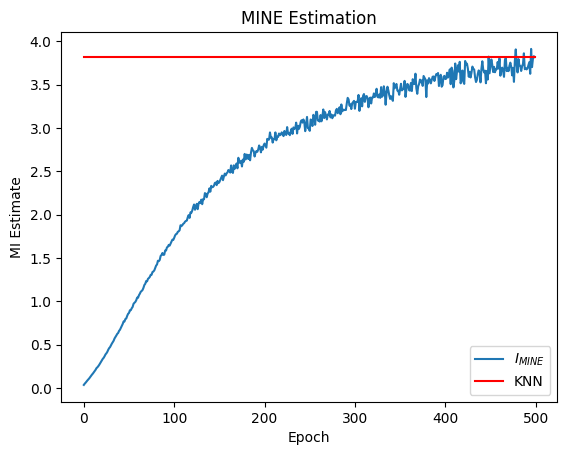

In [9]:
# Estimate MI with KNN
mi_score = np.sum([mutual_info_regression(X[:,[dim]],Z[:,dim]) for dim in range(X.shape[1])])

sns.lineplot(mi_estimates, label='$I_{MINE}$')
plt.plot(range(len(mi_estimates)), np.ones_like(mi_estimates) * mi_estimate, c='r', label='KNN')
plt.xlabel('Epoch')
plt.ylabel('MI Estimate')
plt.legend()
plt.title('MINE Estimation')
plt.savefig('./MINE_Estimate.png')
plt.show()

---